# `diurnal` Library Data Processing Demonstration

This notebook shows how to use the `diurnal` library to download and manipulate
RNA structures.

## Requirements to Execute this Notebook

- A Python virtual environment installed as described in the `readme.rst` file
  of the project.
- Read and write permission in the working directory.
- At least 200 MB of ROM.



In [1]:
# Required imports.
from diurnal import database, family, structure, train, utils, visualize

## Obtain the Data

The module `diurnal.database` can download the following RNA databases:

| Database name  | Number of molecules | URL of the original database
| -------------- | ------------------- | ------------------------------
| archiveII      | 3975 | https://rna.urmc.rochester.edu/pub/archiveII.tar.gz |
| RNASTRalign    | 37149 | https://www.urmc.rochester.edu/rna/ |
| RNA_STRAND     | 4666 | http://www.rnasoft.ca/strand/ |

The code snippet below downloads data:

In [2]:
database.download("./data/", "archiveII")

2024-05-12T10:17:25.731068 > INFO Download and install an RNA database.
2024-05-12T10:17:25.765884 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.


`archiveII` is the name of the dataset to download and `./data/` is the directory in which the data are written. RNA molecules are described with two structures:

- The **primary structure** is a *sequence* of nuclotides, which is represented by a string of four characters: `A`, `C`, `G`, and `U`.
- The **secondary structure** describes the *pairing* of nucleotides, which is represented in the databases by a list of indices. The value `0` indicates that a nucleotide is unpaired.

The primary and secondary structures of each RNA molecule is stored in a CT file. Let's inspect the file `archiveII/5s_Acanthamoeba-castellanii-1.ct`:

In [3]:
with open("./data/archiveII/5s_Acanthamoeba-castellanii-1.ct") as file:
    lines = file.readlines()
    print(f"The file comprises {len(lines)} lines.")
    n = 10
    print(f"The first {n} lines are:")
    print("".join([l for l in lines[:n]]))

The file comprises 120 lines.
The first 10 lines are:
119	5s_Acanthamoeba-castellanii-1
1	G	0	2	118	1
2	G	1	3	117	2
3	A	2	4	116	3
4	U	3	5	115	4
5	A	4	6	114	5
6	C	5	7	113	6
7	G	6	8	112	7
8	G	7	9	111	8
9	C	8	10	110	9



This file describes the complete primary and secondary structures by listing the bases and their pairings.

## Format the Data

This section explains how to convert the content of the CT files into usable data formats.

### Process the content of a CT file

The function `diurnal.utils.rna_data.read_ct_file` can be used to convert CT files into Python objects:

In [4]:
name, primary, secondary = utils.rna_data.read_ct_file(
    "./data/archiveII/5s_Acanthamoeba-castellanii-1.ct"
)

print(f"Name of the molecule: {name}.")
print(f"Primary structure: {primary}.")
print(f"Secondary structure: {secondary}.")

Name of the molecule: 5s_Acanthamoeba-castellanii-1.
Primary structure: ['G', 'G', 'A', 'U', 'A', 'C', 'G', 'G', 'C', 'C', 'A', 'U', 'A', 'C', 'U', 'G', 'C', 'G', 'C', 'A', 'G', 'A', 'A', 'A', 'G', 'C', 'A', 'C', 'C', 'G', 'C', 'U', 'U', 'C', 'C', 'C', 'A', 'U', 'C', 'C', 'G', 'A', 'A', 'C', 'A', 'G', 'C', 'G', 'A', 'A', 'G', 'U', 'U', 'A', 'A', 'G', 'C', 'U', 'G', 'C', 'G', 'C', 'C', 'A', 'G', 'G', 'C', 'G', 'G', 'U', 'G', 'U', 'U', 'A', 'G', 'U', 'A', 'C', 'U', 'G', 'G', 'G', 'G', 'U', 'G', 'G', 'G', 'C', 'G', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'G', 'G', 'G', 'A', 'A', 'U', 'C', 'C', 'A', 'C', 'C', 'G', 'U', 'G', 'C', 'C', 'G', 'U', 'A', 'U', 'C', 'C', 'U'].
Secondary structure: [117, 116, 115, 114, 113, 112, 111, 110, 109, -1, -1, -1, -1, 64, 63, 61, 60, 59, 58, 57, 56, -1, -1, -1, -1, -1, 51, 50, 47, 46, 45, 44, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 31, 30, 29, 28, -1, -1, 27, 26, -1, -1, -1, -1, 20, 19, 18, 17, 16, 15, -1, 14, 13, -1, 107, 106, 105, 104, 103, -1, -1, -1,

Let's check the structures returned by the function:

- The primary structure is a list of characters that each stand for a base. They are listed in the 5' to 3' direction.
- The secondary structure is a list of *pairings*. `-1` indicates that the base is unpaired. Other values indicate the index of the paired base. For instance, the first element of the list is `117`. This means that the first base is paired with the base at index `117`.

These formats are not very useful for training machine learning models, so we'll convert them.

### Convert Primary Structures

A list of characters cannot serve as a raw input to a neural network. There are several ways to convert it to numerical formats.

#### Option 1: One-Hot Encoding

In one-hot encoding, each character is converted to an orthogonal vector. The result is stored in a Numpy array.

In [5]:
print("One-hot encoded primary structure:")
print(structure.Primary.to_onehot(primary))

One-hot encoded primary structure:
[[0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 

#### Option 2: Potential Pairing Matrix

This encoding creates a square matrix whose elements each indicate if a pairing is possible or not.

In [6]:
potential_pairings = structure.Primary.to_matrix(primary)
print("Potential pairings surmised from the primary structure:")
print(potential_pairings)
print(primary)

Potential pairings surmised from the primary structure:
[[[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [1 0 0 ... 0 0 0]]

 ...

 [[0 0 1 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]]

 [[0 0 1 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]]

 [[0 0 0 ... 1 0 0]
  [0 0 0 ... 1 0 0]
  [0 1 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 0]]]


['G', 'G', 'A', 'U', 'A', 'C', 'G', 'G', 'C', 'C', 'A', 'U', 'A', 'C', 'U', 'G', 'C', 'G', 'C', 'A', 'G', 'A', 'A', 'A', 'G', 'C', 'A', 'C', 'C', 'G', 'C', 'U', 'U', 'C', 'C', 'C', 'A', 'U', 'C', 'C', 'G', 'A', 'A', 'C', 'A', 'G', 'C', 'G', 'A', 'A', 'G', 'U', 'U', 'A', 'A', 'G', 'C', 'U', 'G', 'C', 'G', 'C', 'C', 'A', 'G', 'G', 'C', 'G', 'G', 'U', 'G', 'U', 'U', 'A', 'G', 'U', 'A', 'C', 'U', 'G', 'G', 'G', 'G', 'U', 'G', 'G', 'G', 'C', 'G', 'A', 'C', 'C', 'A', 'C', 'C', 'C', 'G', 'G', 'G', 'A', 'A', 'U', 'C', 'C', 'A', 'C', 'C', 'G', 'U', 'G', 'C', 'C', 'G', 'U', 'A', 'U', 'C', 'C', 'U']


That's kinda hard to see, let's visualize it.

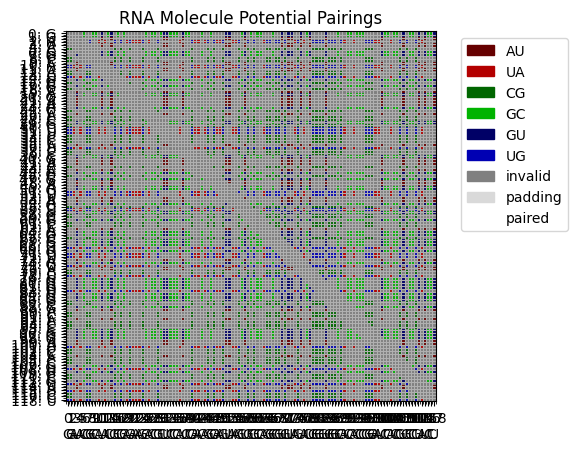

In [7]:
visualize.potential_pairings(primary)

Close up on the upper left corner to examine the pairings.


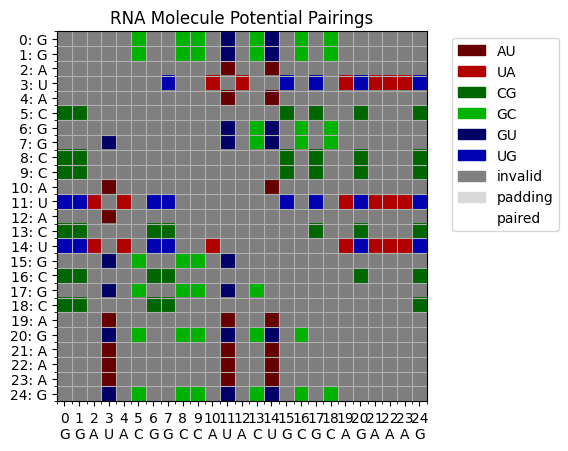

In [8]:
print("Close up on the upper left corner to examine the pairings.")
n = 25
visualize.potential_pairings(primary[:n])

A pairing matrix contains the same information in the upper and lower
triangles. You can use the function `structure.to_half_matrix` to cancel out
the elements in the upper triangle and decrease repetition.

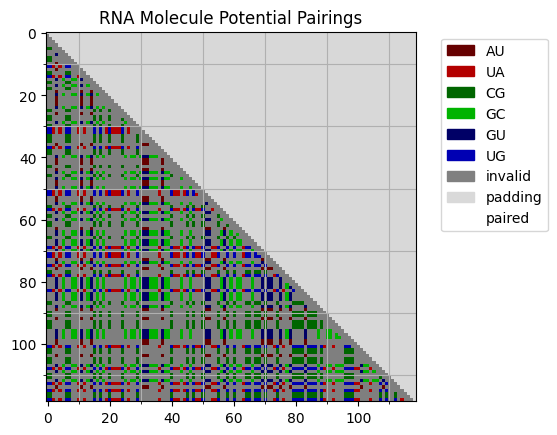

In [9]:
structure.to_half_matrix(
    potential_pairings, structure.Schemes.IUPAC_ONEHOT_PAIRINGS_VECTOR["-"]
)
visualize.potential_pairings(potential_pairings)

Close up on the upper left corner to examine the pairings.


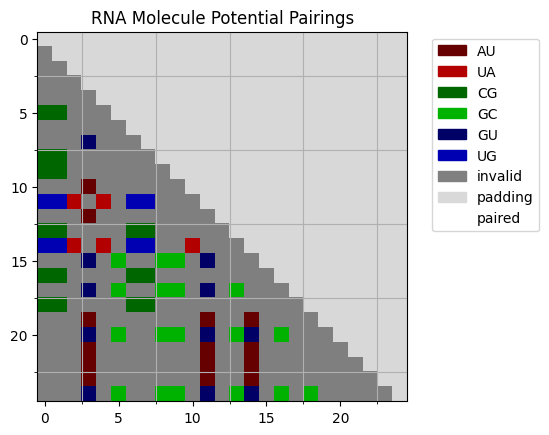

In [23]:
print("Close up on the upper left corner to examine the pairings.")
n = 25
visualize.potential_pairings(potential_pairings[:25, :25])

### Convert Secondary Structures

The list of pairings could be used as the input of an ML model, but it can be converted to more efficient formats.

#### Option 1: Shadow

The shadow is not a complete description of the secondary structure. It simply assigns a different value to paired and unpaired bases, which is useful for some prediction tasks.

In [10]:
print("Shadow of the secondary structure:")
print(structure.Secondary.to_shadow(secondary))
print()

Shadow of the secondary structure:
[1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0
 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 0]



#### Option 2: Bracket-Notation

The bracket notation, or dot-bracket notation, represents unpaired nucleotides with the character `.` and paired nucleotides with the character `(` or `)` depending on whether the paired base is located nearer the 5' or 3' end of the molecule. The bracket notation can then be one-hot encoded. It cannot represent pseudo-knots, so it cannot predict all types of RNA secondary structures.

In [11]:
print("Bracket notation of the secondary structure:")
print(structure.Secondary.to_bracket(secondary))
print()

print("One-hot encoded bracket notation of the secondary structure:")
print(structure.Secondary.to_onehot(secondary))
print()

Bracket notation of the secondary structure:
['(', '(', '(', '(', '(', '(', '(', '(', '(', '.', '.', '.', '.', '(', '(', '(', '(', '(', '(', '(', '(', '.', '.', '.', '.', '.', '(', '(', '(', '(', '(', '(', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ')', ')', ')', ')', '.', '.', ')', ')', '.', '.', '.', '.', ')', ')', ')', ')', ')', ')', '.', ')', ')', '.', '(', '(', '(', '(', '(', '.', '.', '.', '.', '.', '.', '(', '(', '(', '(', '(', '.', '(', '(', '(', '.', '.', '.', '.', ')', ')', ')', ')', ')', ')', ')', ')', '.', '.', '.', '.', '.', ')', ')', ')', ')', ')', '.', ')', ')', ')', ')', ')', ')', ')', ')', ')', '.']

One-hot encoded bracket notation of the secondary structure:
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]


#### Option 3: Contact Matrix

A contact matrix is an n by n matrix of boolean elements. The index of the rows and columns correspond to the index of nucleotides. If two nucleotides are paired, the element that matches their row and column is set to 1. Otherwise, the element is set to 0. This encoding fully represents the secondary structure and can be used to predict pseudo-knots.

In [12]:
print("Contact matrix of the secondary structure:")
contact_matrix = structure.Secondary.to_matrix(secondary)
print(contact_matrix)

Contact matrix of the secondary structure:
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Let's visualize the matrix:

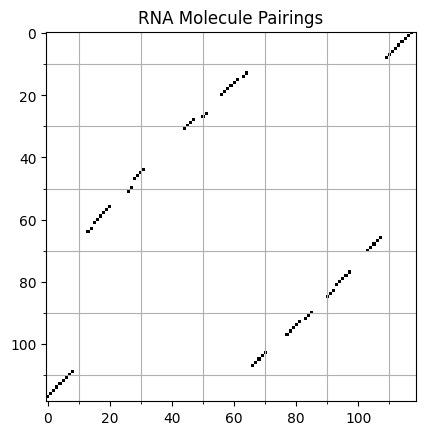

In [13]:
visualize.secondary_structure(contact_matrix)

#### Option 4: Distance Matrix

This is similar to a contact matrix, but instead of being set to 0, unpaired elements are attributed a normalized value that indicates their relative Manhattan distance from the nearest paired base.

In [14]:
print("Distance matrix of the secondary structure:")
distance_matrix = structure.Secondary.to_distance_matrix(secondary)
print(distance_matrix)

Distance matrix of the secondary structure:
[[-0.          0.02272727  0.04545455 ...  0.97727273  1.
   0.97727273]
 [ 0.02272727  0.02272727  0.04545455 ...  1.          0.97727273
   0.97727273]
 [ 0.04545455  0.04545455  0.04545455 ...  0.97727273  0.97727273
   0.95454545]
 ...
 [ 0.97727273  1.          0.97727273 ...  0.29545455  0.29545455
   0.29545455]
 [ 1.          0.97727273  0.97727273 ...  0.29545455  0.27272727
   0.27272727]
 [ 0.97727273  0.97727273  0.95454545 ...  0.29545455  0.27272727
   0.25      ]]


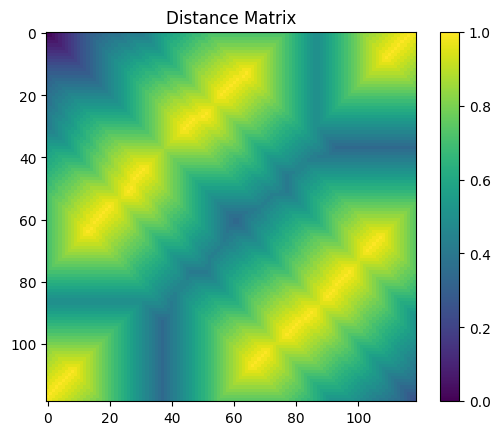

In [15]:
visualize.heatmap(distance_matrix, "Distance Matrix")

The elements of the matrix range from about 0.6 to 1. We can stretch these values so that they range from 0 to 1, which can help compare different secondary structures.

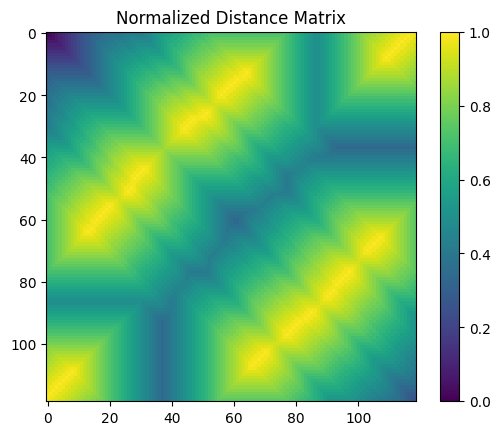

In [16]:
normalized = structure.Secondary.normalize_distance_matrix(distance_matrix)
visualize.heatmap(normalized, "Normalized Distance Matrix")

## Prepare Training Data

Pre-processing the content of CT file each time a model is trained is time consuming. You can instead process the CT files and dump the resulting numerical formats into Numpy files that can be retrieved later. At this stage, you can also divide the RNA molecules into distinct sets.

### Format Names

In [17]:
SRC = "./data/archiveII/"  # Input directory containing the CT files.
DST = "./data/processed_archiveII/"  # Output directory of the formatted files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).

In [18]:
# Format the names of the molecules.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)

2024-05-12T10:17:28.320298 > INFO Extract the filenames from the directory `./data/archiveII/`.
2024-05-12T10:17:58.794440 >    0 / 3975 [                                                  ] 16s_A.fulgidus.ct>    1 / 3975 [                                                  ] 16s_A.fulgidus_domain1.ct>    2 / 3975 [                                                  ] 16s_A.fulgidus_domain2.ct>    3 / 3975 [                                                  ] 16s_A.fulgidus_domain3.ct>    4 / 3975 [                                                  ] 16s_A.fulgidus_domain4.ct>    5 / 3975 [                                                  ] 16s_A.pyrophilus.ct>    6 / 3975 [                                                  ] 16s_A.pyrophilus_domain1.ct>    7 / 3975 [                                                  ] 16s_A.pyrophilus_domain2.ct>    8 / 3975 [                                                  ] 16s_A.pyrophilus_domain3.ct>    9 / 3975 [                                          

In [19]:
print(f"{len(names)} molecule names have been selected.")

2326 molecule names have been selected.


The list `names` contains the file paths of all the CT files in the `archiveII` database that contain molecules whose length is inferior or equal to 128. By default, the order of the molecules is randomized to help prevent bias during training.

We can now split the names into distinct sets.

### Homogeneous Data Splitting

With this approach, all RNA structures are placed in a random order and then split in different sets.

In [20]:
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

This function creates three lists of `str` objects. `train_names` contains 80 % of the names listed in the original list whereas `validation_names` and `test_names` each contain 10 % of the names. **There are no duplicates across sets**.

### Inter-Family Data Splitting

With this approach, RNA structures are divided according to their family, which is useful when testing for over-fitting.

In [21]:
test_family = "5s"
non_test_families = family.all_but(test_family)
print(f"Non-test families include: {non_test_families}")

test_set = family.select(names, test_family)
non_test_set = family.select(names, non_test_families)
train_set, validation_set = train.split(non_test_set, (0.9, 0.1))

Non-test families include: ['16s', '23s', 'grp1', 'grp2', 'RNaseP', 'SRP', 'telomerase', 'tmRNA', 'tRNA']


### Write Formatted Sets Into Files

Once the list of molecule names are divided into sets, you can use the functions `database.format_primary_structure` and `database.format_secondary_structure` to format the corresponding CT files into Numpy arrays and write them on disk.

In [22]:
database.format_primary_structure(
    test_set,
    f"{DST}test_primary_structures.npy",
    SIZE,
    structure.Primary.to_onehot
)
database.format_primary_structure(
    train_set,
    f"{DST}train_primary_structures.npy",
    SIZE,
    structure.Primary.to_onehot
)

database.format_secondary_structure(
    test_set,
    f"{DST}test_secondary_structures.npy",
    SIZE,
    structure.Secondary.to_matrix
)
database.format_secondary_structure(
    train_set,
    f"{DST}train_secondary_structures.npy",
    SIZE,
    structure.Secondary.to_matrix
)

2024-05-12T10:17:58.886251 > INFO Formatting primary structures into `./data/processed_archiveII/test_primary_structures.npy`.
2024-05-12T10:18:02.523863 >    0 / 1269 [                                                  ] data\archiveII\5s_Fusarium-asiaticum-4.ct>    1 / 1269 [                                                  ] data\archiveII\5s_Thiomicrospira-pelophila-1.ct>    2 / 1269 [                                                  ] data\archiveII\5s_Hydrurus-foetidus-1.ct>    3 / 1269 [                                                  ] data\archiveII\5s_Mycoplasma-sp.-1.ct>    4 / 1269 [                                                  ] data\archiveII\5s_Ancylobacter-aquaticus-1.ct>    5 / 1269 [                                                  ] data\archiveII\5s_Clostridium-acetobutylicum-4.ct>    6 / 1269 [                                                  ] data\archiveII\5s_Protomyces-inundatus-1.ct>    7 / 1269 [                                                  ] data\arc

The functions will take the list of molecule names and write the formatted files in the provided directory. Molecules are padded with elements so that their size matches the provided `SIZE`. This is necessary to ensure that vector dimensions are homogeneous. If you try to write two arrays of differing dimensions into the same file, Numpy will kick and scream. The last argument is a function that transforms the structure (i.e. a list a characters for the primary structure and a list of pairings for the secondary structure) into a vector. You can provide your own custom functions as the last parameter.